# **Using GANs to Create Monet Style Art (CycleGAN)**

Table of Contents:
* [About the Data / Project](#about)
* [Set Up](#set)
* [Exploratory Data Analysis](#eda)
* [Building the Generator](#gen)
* [Building the Discriminator](#disc)
* [Building CycleGAN](#gan)
* [Defining Loss Functions](#loss)
* [Training the Model](#model)
* [Results](#results)
* [Submission](#sub)
* [Conclusion](#conclusion)
* [References](#ref)

<a id="about"></a>
# **About the Data / Project**

This dataset can be found in the [Kaggle](https://www.kaggle.com/competitions/gan-getting-started) "I'm Something of a Painter Myself" competition. The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet directories contain 300 Monet paintings with a size of 256x256 pixels. The monet_jpg directory contains these 300 paintings in JPEG format, while the monet_tfrec directory contains them in TFRecord format. The photo directories contain 7028 photos sized 256x256 pixels. Again, photo_jpg and photo_tfrec have the photos in JPEG and TFRecord format, respectively. 

The task of this competition and therefore this project is to develop a generative adversarial network (GAN) which will work to convert regular photos into Monet style paintings. According to Kaggle, a GAN is made up of at least two neural networks, i.e. a generator model and a discriminator model. As this is an adversarial model, the generator and the discriminator will work in opposition to eventually create more and more realistic Monet style images. In this project, I will employ the use of [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan). According to the tensorflow website, CycleGAN is able to train without the use of paired data, as the GAN employs an additional cycle consistency loss function. This proves to be beneficial, as CycleGAN can translate between two domains without having a one-to-one mapping between them. Because of this, CycleGAN is able to do tasks such as style transfer, which is the main objective of this project.  

<a id="set"></a>
# **Set Up**

In [ ]:
# Loading necessary packages
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from kaggle_datasets import KaggleDatasets

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

In [ ]:
# Loading monet and photo directories for EDA
monet_eda = "../input/gan-getting-started/monet_jpg"
photo_eda = "../input/gan-getting-started/photo_jpg"

In [ ]:
# Creating image_path function to retrieve image paths from directory
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [ ]:
# Applying image_path function to monet_eda and photo_eda datasets
monet_eda1 = image_path(monet_eda)
photo_eda1 = image_path(photo_eda)

In the code chunks above, the monet_jpg and photo_jpg directories have been imported and loaded for the sole use of a brief exploratory data analysis. Below,the .tfrec directories will be loaded and used for the CycleGAN model. 

In [ ]:
# Creating path for .tfrec directories
path = KaggleDatasets().get_gcs_path()

In [ ]:
# Pulling in filenames of monet_tfrec and photo_tfrec
monet_filenames = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
photo_filenames = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))

In [ ]:
# Checking number of monet and photo TFRecord files
print('Monet TFRecord Files: ', len(monet_filenames))
print('Photo TFRecord Files: ', len(photo_filenames))

Above, we can see the number of TFRecord filenames in the monet and photo datasets. This files include the 300 Monet images and 7038 photos which we will load in soon.

In [ ]:
# Creating decode_image function
IMAGE_SIZE = [256, 256]
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [ ]:
# Creating read_tfrecord function
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

The functions decode_image and read_tfrecord above will work to help extract images from the monet_filenames and photo_filenames datasets. All images in the datasets are already set to 256x256 pixels and the channel has been set to 3, as all images are RGB images. The functions above will scale these images to a [-1,1] scale and will remove labels and image ids. 

In [ ]:
# Creating load_dataset function
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
# Loading in datasets with images
monet_ds = load_dataset(monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(1)

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

<a id="eda"></a>
# **Exploratory Data Analysis**

In [ ]:
# Viewing number of images in monet and photo datasets
print("Monet Images: ", len(monet_eda1))
print("Photo Images: ", len(photo_eda1))

Above, we can confirm the amount of images in each dataset. There are 300 images in the monet dataset and 7038 images in the photo dataset. It should be noted that while Kaggle states that there are 7028 photos in the photo directories, the code chunk above has yielded a number of 7038. Fortunately, this is a relatively small difference, and thus will not likely affect the training. 

In [ ]:
# Creating display function to show image examples
def display(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

In [ ]:
# Viewing examples of images in monet_eda dataset
display(monet_eda1,3,3)

In [ ]:
# Viewing examples of images in photo_eda dataset
display(photo_eda1,3,3)

Above, we can see several examples of the Monet paintings and the photos that are available in the datasets. At a glance, there is an obvious difference between the example sets. The photos are clear images while the Monet paintings have somewhat of a softer resolution. It will definitely be interesting to see how the GAN converts the photos into a Monet style work. 

<a id="gen"></a>
# **Building the Generator**

As this is my first attempt at using CycleGAN, the following sections has been heavily influenced by a model tutorial created by [Amy Jang](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial). 

In [ ]:
# Creating downsample function
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result

The downsample function above works to reduce the dimensions (height and width) of images by a stride of 2. 

In [ ]:
# Creating upsample function
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

The upsample function above works in an opposite manner when compared to the downsample function. Instead, the upsample function works to increase the dimensions of images by a stride of 2. 

In [ ]:
# Creating the Generator! 
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Above is the generator function! This function downsamples and then upsamples input images. Skip connections are used in the upsample stage in order to avoid and remedy the vanishing gradient problem. Overall, the generator will work to produce images that the discriminator will classify as real or generated.

<a id="disc"></a>
# **Building the Discriminator**

In [ ]:
# Creating the Discriminator! 
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

The discriminator above takes an image created from the generator and determines whether or not the image is real or fake. The output here is another image. If the image has higher pixel values, then the discriminator has determined the input to be real. If the image has lower pixel values, then the input image is determined to be fake. 

In [ ]:
# Adding to distribution strategies
with strategy.scope():
    monet_generator = Generator() 
    photo_generator = Generator() 

    monet_discriminator = Discriminator() 
    photo_discriminator = Discriminator() 

The code chunk above does the following:
- monet_generator: This transforms photos into Monet style paintings
- photo_generator: This works backwards. It transforms Monet paintings into regular photos.
- monet_discriminator: This determines whether or not an image is a real Monet painting or a generated painting.
- photo_discriminator: This determines whether or not an image is a real photo or a generated photo.

<a id="gan"></a>
# **Building CycleGAN**

In [ ]:
# Creating CycleGan class
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
         # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

<a id="loss"></a>
# **Defining Loss Functions**

In [ ]:
# Adding to distribution strategies
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

<a id="model"></a>
# **Training the Model**

In [ ]:
# Adding to distribution strategies
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
# Fitting the model!
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

<a id="results"></a>
# **Results**

Below are the best results yielded from the CycleGAN model:

- monet_gen_loss: 2.6839, epoch=25
- photo_gen_loss: 2.7724, epoch=25
- monet_disc_loss: 0.6129, epoch=13
- photo_disc_loss: 0.5300, epoch=3

From the information above, it can be argued that the generator of the CycleGAN model performed best at the highest number of epochs (25). In contrast, the discriminator tended to perform better at earlier epochs. 

In [ ]:
# Visualizing the new images in Monet style
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Style Output")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Above, we can see examples of input photos and their Monet style outputs. Overall, the output images obtain the softer resolution that appears to resemble a Monet painting. In my opinion, the best looking example here is the one of the water under the bridge:

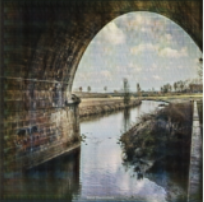

Here, you can see that the image lacks the resolution that would obviously make it a real photo. A blending of the colors and borders of objects definitely makes this appear closer to a Monet painting. In contrast, the photo below appears to not have experienced much change:

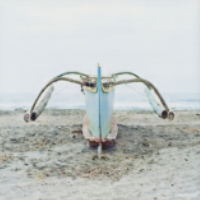

This may be due to the fact that the input photo had less variation in its palette. In other words, the pale blue sky and sand makes the image more monochrome and thus the resulting Monet style painting is unable to take advantage of blending various shapes and colors together. 

<a id="sub"></a>
# **Submission**

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

<a id="conclusion"></a>
# **Conclusion**

By employing the use of CycleGAN, I was able to convert photos into Monet style paintings. When training the CycleGAN model, 25 epochs were used. In general, the loss of the generator portion of the model tended to improve across epochs and was the lowest at the 25th epoch. In contrast to this, the loss of the discriminator tended to fluctuate across epochs and was actually lowest at lower epochs. Future iterations of this project could employ a higher number of epochs, such as 30. It is likely that the loss from the generator would continue to decrease but the loss from the discriminator would likely fluctuate and even increase.

Thank you for taking the time to view my project. Please feel free to leave a like! 

<a id="ref"></a>
# **References**

- https://www.kaggle.com/competitions/gan-getting-started
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://www.kaggle.com/code/ruchi798/getting-started-with-gans
- https://www.kaggle.com/code/doanquanvietnamca/the-beauty-of-cyclegan/notebook
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial